# What will be the best block to pick-up customers for each day of the week of a month?


## Preamble

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

## Load the data

In [2]:
df=pd.read_csv("datasets/yellow_tripdata_2013-01.csv")

## Preprocess data

In [3]:
#create new column call weekday
timestamp = pd.to_datetime(pd.Series(df['pickup_datetime']))
df['weekday'] = timestamp.dt.weekday_name
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,weekday
0,CMT,2013-01-01 15:11:48,2013-01-01 15:18:10,4,1.0,-73.978165,40.757977,1,N,-73.989840,40.751173,CSH,6.5,0.0,0.5,0.0,0.0,7.0,Tuesday
1,CMT,2013-01-06 00:18:35,2013-01-06 00:22:54,1,1.5,-74.006680,40.731781,1,N,-73.994499,40.750659,CSH,6.0,0.5,0.5,0.0,0.0,7.0,Sunday
2,CMT,2013-01-05 18:49:41,2013-01-05 18:54:23,1,1.1,-74.004711,40.737770,1,N,-74.009831,40.726000,CSH,5.5,1.0,0.5,0.0,0.0,7.0,Saturday
3,CMT,2013-01-07 23:54:15,2013-01-07 23:58:20,2,0.7,-73.974600,40.759945,1,N,-73.984737,40.759388,CSH,5.0,0.5,0.5,0.0,0.0,6.0,Monday
4,CMT,2013-01-07 23:25:03,2013-01-07 23:34:24,1,2.1,-73.976252,40.748528,1,N,-74.002583,40.747867,CSH,9.5,0.5,0.5,0.0,0.0,10.5,Monday


In [4]:
#drop unnecessary column
df = df.drop(['vendor_id','passenger_count','trip_distance','rate_code',
              'store_and_fwd_flag','payment_type','fare_amount','surcharge','mta_tax',
             'tip_amount','tolls_amount','total_amount','dropoff_datetime',
              'dropoff_longitude','dropoff_latitude'], axis=1)

#get rid off some garbage data
df=df[(df['pickup_latitude'] > 40.492083) & (df['pickup_latitude']<40.944536) &
     (df['pickup_longitude']> -74.267880)& (df['pickup_longitude']< -73.662022)]

df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,weekday
0,2013-01-01 15:11:48,-73.978165,40.757977,Tuesday
1,2013-01-06 00:18:35,-74.006680,40.731781,Sunday
2,2013-01-05 18:49:41,-74.004711,40.737770,Saturday
3,2013-01-07 23:54:15,-73.974600,40.759945,Monday
4,2013-01-07 23:25:03,-73.976252,40.748528,Monday


In [5]:
#get all the selected weekdays in selected month
my_weekday="Tuesday"
my_montn=1
df_select=df[(df['weekday']==my_weekday) & 
                 (pd.to_datetime(df['pickup_datetime']) < pd.datetime(2013,my_montn+1,1))&
                (pd.to_datetime(df['pickup_datetime']) > pd.datetime(2013,my_montn,1))]
df_select.head()


,pickup_datetime,pickup_longitude,pickup_latitude,weekday
0,2013-01-01 15:11:48,-73.978165,40.757977,Tuesday
6,2013-01-08 11:01:15,-73.995801,40.743978,Tuesday
10,2013-01-08 13:11:52,-73.982456,40.773167,Tuesday
11,2013-01-08 09:50:05,-73.995561,40.749295,Tuesday
22,2013-01-08 13:29:25,-73.955778,40.779318,Tuesday


## Kmean Clustering

In [29]:
%%time
#use Kmean to group data by longitude and latitude
my_cluster=200
from sklearn.cluster import KMeans
lon=df_select['pickup_longitude'].values
lat=df_select['pickup_latitude'].values
coodinate_array=np.array([[lon[i],lat[i]] for i in range(len(lon))])

kmeans_n = KMeans(n_clusters=my_cluster,  n_init=1)
kmeans_n.fit(coodinate_array)
labels = kmeans_n.labels_
print(labels)

[ 87   1  61 ...,  13   4 165]
CPU times: user 5min 51s, sys: 12.2 s, total: 6min 4s
Wall time: 5min 28s


In [30]:
# add new column call cluster
df_select['Cluster']=labels
df_select.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,pickup_datetime,pickup_longitude,pickup_latitude,weekday,Cluster
0,2013-01-01 15:11:48,-73.978165,40.757977,Tuesday,87
6,2013-01-08 11:01:15,-73.995801,40.743978,Tuesday,1
10,2013-01-08 13:11:52,-73.982456,40.773167,Tuesday,61
11,2013-01-08 09:50:05,-73.995561,40.749295,Tuesday,104
22,2013-01-08 13:29:25,-73.955778,40.779318,Tuesday,198


In [31]:
#prepare for regression
Cluster_size=df_select.groupby('Cluster').size()
Cluster_size=np.array([[Cluster_size[i]] for i in range(len(Cluster_size))])
Cluster_center=kmeans_n.cluster_centers_

## Training data and testing data

In [32]:
train_size=int(len(Cluster_size)*0.8)
test_size=int(len(Cluster_size)*0.2)
train_feature=Cluster_size[:train_size]
train_response=Cluster_center[:train_size]
test_feature=Cluster_size[test_size:]
test_response=Cluster_center[test_size:]

## Validation

In [33]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


def fit_model(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X, y)
    return model

def score_model(model, X, y, Xv, yv):
    return tuple([model.score(X, y), model.score(Xv, yv)])

def fit_model_and_score(data, response, validation, val_response):
    model = fit_model(data, response)
    return score_model(model, data, response, validation, val_response)

print (fit_model_and_score(train_feature, train_response,
                           test_feature, test_response))


(0.034566824588257987, 0.051918074202050087)


## Prediction

In [34]:
#predict best location

X=Cluster_size
y=Cluster_center

model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
model.fit(X, y)
X_predict=(max(Cluster_size))
y_predict = model.predict(X_predict)
y_predict


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[-73.97826814,  40.74857845]])

## Visualization

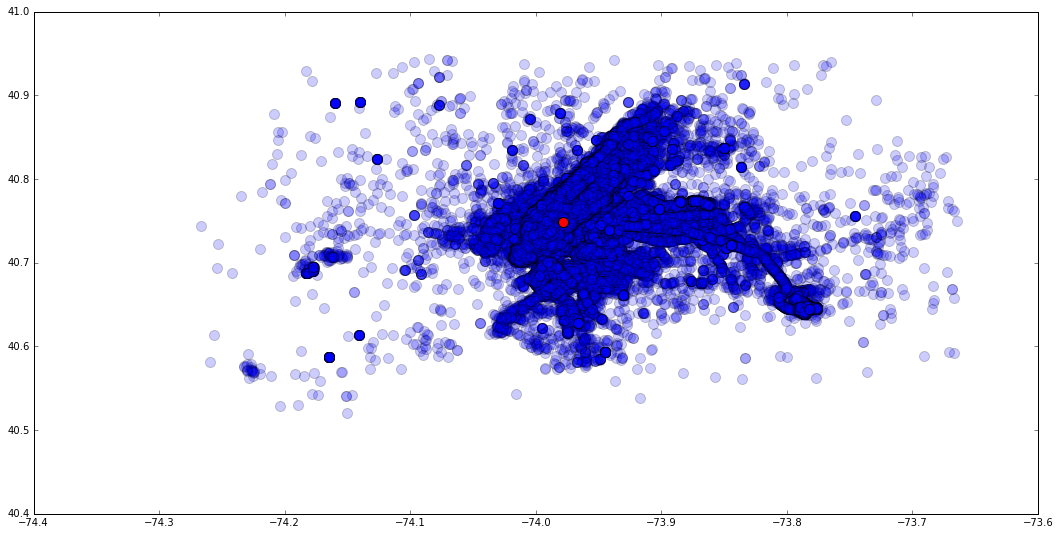

In [35]:
#scatter plot all the data for selected weekday and prediction
x_points=lon
y_points=lat
plt.figure(figsize=(18,9))
plt.scatter(lon,lat,alpha=0.2,s=100)
plt.scatter(-73.97826814, 40.74857845 ,c='r',s=100)
plt.show()


use link here to check visualization on carto if below codes don't show map
https://shenghuayou.carto.com/builder/ac7e268c-b4ee-11e6-b213-0e98b61680bf/embed

In [13]:
#load data from carto (data for 2013/01/01 Tuesday)
from IPython.display import HTML
HTML('<iframe width=100% height=520 frameborder=0 src=https://shenghuayou.carto.com/builder/ac7e268c-b4ee-11e6-b213-0e98b61680bf/embed allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')